<a href="https://colab.research.google.com/github/shoiTK/deep_learning_with_pytorch/blob/main/training_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a classifier

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

In [32]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'trauck')


Files already downloaded and verified
Files already downloaded and verified


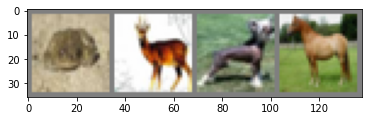

 frog  deer   dog horse


In [33]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [34]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [39]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [40]:
for epoch in range(2):

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    
    inputs, labels = data
    inputs, labels = inputs.cuda(), labels.cuda()#calcurate on GPU
    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss/2000 ))
      running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 1.426
[1,  4000] loss: 1.386
[1,  6000] loss: 1.370
[1,  8000] loss: 1.331
[1, 10000] loss: 1.335
[1, 12000] loss: 1.299
[2,  2000] loss: 1.250
[2,  4000] loss: 1.247
[2,  6000] loss: 1.220
[2,  8000] loss: 1.212
[2, 10000] loss: 1.190
[2, 12000] loss: 1.223
Finished Training


In [16]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


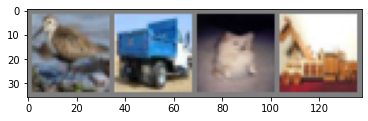

GroundTruth:   bird trauck   dog trauck


In [22]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [23]:
net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:   frog trauck   dog   car


In [25]:
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  print('Accuracy of the netwaork on the 10000 test images: %d %%' % (100 * correct/total))

Accuracy of the netwaork on the 10000 test images: 60 %


In [28]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i]/class_total[i]))

Accuracy of plane : 62 %
Accuracy of   car : 65 %
Accuracy of  bird : 38 %
Accuracy of   cat : 34 %
Accuracy of  deer : 62 %
Accuracy of   dog : 54 %
Accuracy of  frog : 73 %
Accuracy of horse : 66 %
Accuracy of  ship : 76 %
Accuracy of trauck : 73 %


In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
inputs, labels = inputs.cuda(), labels.cuda()

cuda:0


In [31]:
net.to(device)
inputs, labels = inputs.cuda(), labels.cuda()